In [1]:
from options import Options
from grid import Grid
from trajectory_generator import generate_trajectory
import torch
import numpy as np
import plotting
import analysis
import os
%load_ext autoreload
import utils
import matplotlib.pyplot as plt
from train_RNN import TrainableNetwork, RNN_options, Trainer
%autoreload 2

sim_path = os.getcwd() + '/sim_data/'

### 1. Build and intiialize network

In [2]:
options = Options()
options.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device :', options.device)
grid = Grid(options)

device : cuda
Recovering pre-computed matrix found at /home/onyxia/work/grid_cells_burak_fiete/models/Wmat_beta=0.013333333333333334_gamma=0.015333333333333332_periodic=True_a=1.5_l=0.5_n=40.pth
Restoring pre-computed initial state found at /home/onyxia/work/grid_cells_burak_fiete/models/s0_beta=0.013333333333333334_gamma=0.015333333333333332_periodic=True_a=1.5_l=0.5_n=40_tau=0.01_alpha=0.2_tiling=deterministic_device=cuda_solver=euler_dt=0.0001.pth


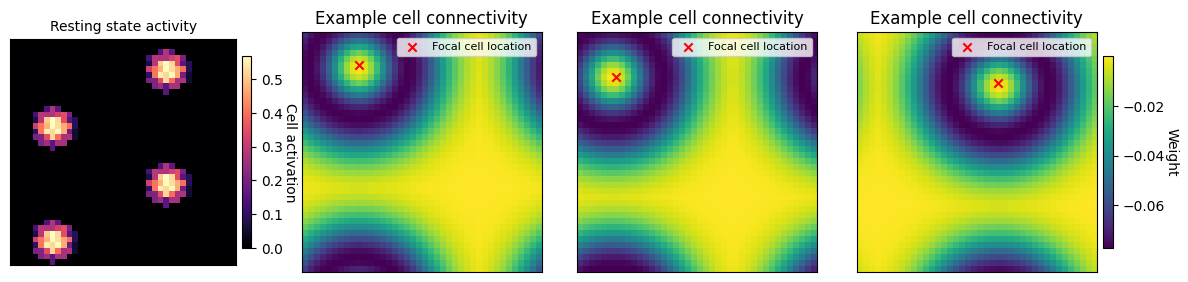

In [3]:
_ = plotting.network_presentation(grid)

### 2. Integrate random trajectory

Found pre-computed trajectory at /home/onyxia/work/grid_cells_burak_fiete/sim_data/trajectory_len=100000_dt=0.0001_w=2.2_h=2.2_rotvelstd=1.6_meanv=0.8_border=0.03_borderslow=0.25.npy, loading it
loading pre-computed trajectory at /home/onyxia/work/grid_cells_burak_fiete/sim_data/example_sim_T=10_dt=0.0001_beta=0.013333333333333334_gamma=0.015333333333333332_periodic=True_a=1.5_l=0.5_n=40_tau=0.01_alpha=0.2_tiling=deterministic_device=cuda_solver=euler_dt=0.0001.pth
labeling blobs


100%|██████████| 10000/10000 [00:00<00:00, 19171.28it/s]


detected less than 8 blobs per frame
computing blob centers


/opt/conda/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
100%|██████████| 10000/10000 [00:01<00:00, 6213.38it/s]


found 24 best blob jumps : interpolating speed between them
Estimated prediction to truth size ratio = 0.0643, R2=0.999


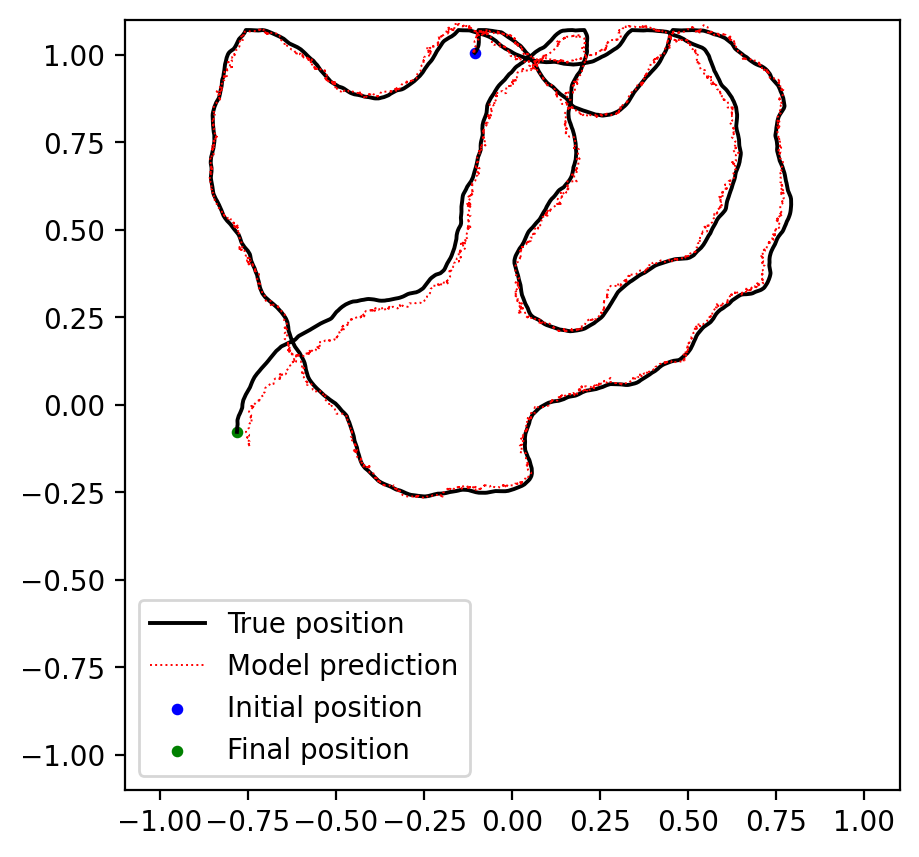

In [4]:
# generate a trajectory 
box_width = box_height = 2.2 # m 
T = 10 # s
dt = grid.options.dt
seq_len = int(T/dt)

trajectory = generate_trajectory(box_width, box_height, seq_len, load=True, save=True, batch_size = 1, silent=False)

torch.cuda.empty_cache()
pos = np.stack([trajectory['target_x'].squeeze(), trajectory['target_y'].squeeze()], 1)
v_inputs = np.diff(pos, axis=0)/dt

fname = f"example_sim_T={T}_dt={dt}_{grid.grid_id}.pth"
grid.save_sim = True
S = grid.simulate(v_inputs, sim_id = fname, silent=False, load=True) # set load = false to restart a new sim from scratch

# downsample if needed for faster analysis 
new_dt = 1E-3
S = utils.downsample(S, new_dt=new_dt, old_dt = dt)
pos = utils.downsample(pos, new_dt=new_dt, old_dt = dt)

pos_pred, prop_factor, r2 = analysis.model_prediction(S, pos, verb = True)

plotting.compare_model_prediction(pos_pred, pos, box_width = box_width, box_height = box_height)

### Idées pour la suite :

- Entrainer un RNN (approche normative/optimale) cf https://github.com/ganguli-lab/grid-pattern-formation (publié sur Neuron, j'ai testé un peu l'approche et ca fonctionne, suffit de reprendre leur code ou de recoder une version + simple) => Comparer le résultat du RNN et du modele de burak

- Regarder la topologie du réseau (topologie torique ?) -> reduction de la dimensionalité de la matrice de connectivité et / ou de l'activité neuronale. Comparer eventuellement avec le RNN 

In [5]:
rnn_opt = RNN_options()
network = TrainableNetwork(rnn_opt)
trainer = Trainer(network)

rnn_opt.learning_rate = 1E-4
vars(rnn_opt)

Initializing new model from scratch.
Saving to: /home/onyxia/work/grid_cells_burak_fiete/models/n_steps_100000_batch_size_200_sequence_length_20_learning_rate_1e-05_pc_sheet_size_23_gc_sheet_size_40_pc_sigma_0.12_activation_tanh_weight_decay_0.0001_box_width_2.2_dt_0.01_device_cuda


{'save_dir': '/home/onyxia/work/grid_cells_burak_fiete/models/',
 'n_steps': 100000,
 'batch_size': 200,
 'sequence_length': 20,
 'learning_rate': 0.0001,
 'pc_sheet_size': 23,
 'gc_sheet_size': 40,
 'pc_sigma': 0.12,
 'activation': 'tanh',
 'weight_decay': 0.0001,
 'box_width': 2.2,
 'dt': 0.01,
 'device': 'cuda'}

In [ ]:
n_steps = 100000
n_epochs = 10
trainer.train(n_epochs, n_steps)

Epoch 0/10 step 2253/100000 : Loss 4.48 Error =  81.5 cm:   0%|          | 0/100000 [01:12<?, ?it/s]

In [ ]:
rnn_opt._str()

In [54]:
vars(rnn_opt)

{'n_steps': 100000,
 'batch_size': 200,
 'sequence_length': 20,
 'learning_rate': 0.0001,
 'pc_sheet_size': 512,
 'gc_sheet_size': 40,
 'pc_sigma': 0.12,
 'activation': 'relu',
 'weight_decay': 0.0001,
 'box_width': 2.2,
 'box_height': 2.2,
 'dt': 0.01}

In [55]:
rnn_opt.save_dir

AttributeError: 'RNN_options' object has no attribute 'save_dir'